<a href="https://colab.research.google.com/github/bilgenurcakir/clip-semantic-risk-analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

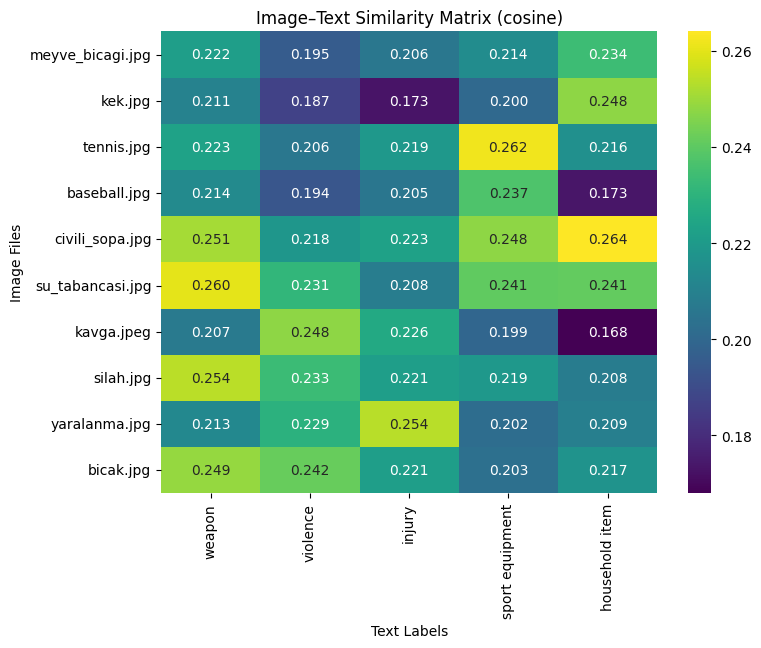


Tahmin edilen eşleşmeler:



In [27]:


import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

image_paths = [
   "images/meyve_bicagi.jpg",
   "images/kek.jpg",
    "images/tennis.jpg",
    "images/baseball.jpg",


    "images/civili_sopa.jpg",
    "images/su_tabancasi.jpg",
    "images/kavga.jpeg" ,
    "images/silah.jpg",
    "images/yaralanma.jpg",
    "images/bicak.jpg"

]
for p in image_paths:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Görsel bulunamadı: {p}. Yükleyin.")



text_labels = [
    "weapon",
    "violence",
    "injury",
    "sport equipment",
    "household item",



]



device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

images = [Image.open(p).convert("RGB") for p in image_paths]

inputs = processor(
    text=text_labels,
    images=images,
    return_tensors="pt",
    padding=True
).to(device)



#  Embedding

with torch.no_grad():
    image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    text_features = model.get_text_features(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )


# Projeksiyon + Normalizasyon

image_norm = F.normalize(image_features, p=2, dim=1)
text_norm = F.normalize(text_features, p=2, dim=1)

similarity = image_norm @ text_norm.T
sim_np = similarity.detach().cpu().numpy()



# Heatmap

plt.figure(figsize=(8,6))
sns.heatmap(
    sim_np,
    annot=True, fmt=".3f", # Hücrelere benzerlik değerleri (3 ondalık hassasiyetle)
    xticklabels=text_labels,
    yticklabels=[os.path.basename(p) for p in image_paths],
    cmap="viridis"
)
plt.title("Image–Text Similarity Matrix (cosine)")
plt.xlabel("Text Labels")
plt.ylabel("Image Files")
plt.show()


#  Prediction

pred_indices = similarity.argmax(dim=1).cpu().numpy()
pred_labels = [text_labels[i] for i in pred_indices]

print("\nTahmin edilen eşleşmeler:\n")

plt.figure(figsize=(12, 20))

for i, p in enumerate(image_paths):
    img = Image.open(p).convert("RGB")

    score = sim_np[i, pred_indices[i]]
    label = pred_labels[i]

    plt.subplot(len(image_paths), 1, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(p)} ➜ {label}  (score={score:.3f})", fontsize=12)

plt.tight_layout()
plt.show()


#  Zararlı / Zararsız Kararı

print("\nZararlı / Zararsız Analizi (Class Yok):\n")

# Anlamsal gruplama (etiket değil, analiz için)
risk_like = ["weapon", "violence", "injury"]
safe_like = ["sport equipment", "household item"]

for i, p in enumerate(image_paths):

    # Risk benzerliklerinin ortalaması
    risk_score = np.mean([
        sim_np[i, text_labels.index(lbl)]
        for lbl in risk_like
    ])

    # Güvenli benzerliklerin ortalaması
    safe_score = np.mean([
        sim_np[i, text_labels.index(lbl)]
        for lbl in safe_like
    ])

    margin = risk_score - safe_score

    if margin > 0:
        status = "POTENTIALLY HARMFUL"
        out_score = risk_score
    else:
        status = "LIKELY SAFE"
        out_score = safe_score

    print(
        f"{os.path.basename(p):15s} | "
        f"risk={risk_score:.3f} | "
        f"safe={safe_score:.3f} | "
        f"margin={margin:.3f} → {status}"
    )